In [1]:
import numpy as np
import pandas as pd
import os

import re
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 491K Jan 15 18:18 data/69-.paralel.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  48M Jan 15 18:21 data/Russia.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  12M Jan 15 18:21 data/Sil_struktur.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  44K Jan 15 18:19 data/biblioteka.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  25M Jan 15 18:19 data/bivs.SSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 6.1M Jan 15 18:18 data/biznes.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 2.9M Jan 15 18:21 data/cennosti.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  28M Jan 15 18:21 data/economic.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  16M Jan 15 18:19 data/internet.i.smi.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.6M Jan 15 18:18 data/iz.jizni.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 125K Jan 15 18:18 data/kultprosvet.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  20M Jan 15 18:18 data/kultura.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 

In [4]:
name_dataset = 'mir'

### load data

In [27]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(149880, 7)
CPU times: user 18.6 s, sys: 185 ms, total: 18.8 s
Wall time: 18.8 s


In [28]:
df = df[df.text!='text']
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/finnair/,NaN,Россия,Финны отказались летать в Россию на Новый год,Финская авиакомпания Finnair отменила рейсы из...,Мир
2,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/japan_nuclear/,NaN,Мир,"Ядерная авария в Японии: 55 облученных, цепная...","Японские власти заявили, что им удалось справи...",Мир


### preprocess

* get dates

In [29]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

CPU times: user 674 ms, sys: 7.97 ms, total: 682 ms
Wall time: 679 ms


<unknown>:2: DeprecationWarning: invalid escape sequence \d


* clean text

In [30]:
import preprocessing_tools as pr

In [31]:
%%time
df.text = df.text.apply(pr.clean_text)

CPU times: user 23.3 s, sys: 72 ms, total: 23.3 s
Wall time: 23.3 s


In [32]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/finnair/,NaN,Россия,Финны отказались летать в Россию на Новый год,финская авиакомпания finnair отменила рейсы из...,Мир,"[(1999, 10, 01)]",1999,10
2,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/japan_nuclear/,NaN,Мир,"Ядерная авария в Японии: 55 облученных, цепная...",японские власти заявили что им удалось справит...,Мир,"[(1999, 10, 01)]",1999,10


* cleanedNames

In [33]:
from cleanedNames import KeyProc
cn = KeyProc()

In [34]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

CPU times: user 3min 49s, sys: 8.05 ms, total: 3min 49s
Wall time: 3min 49s


* lemmatization

In [35]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

CPU times: user 3min 53s, sys: 1.02 s, total: 3min 54s
Wall time: 3min 54s


* add docID

In [36]:
df['docID'] = list(range(df.shape[0]))

In [37]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
1,0,1999,10,"[финский, авиакомпания, finnair, отменить, рей..."
2,1,1999,10,"[японский, власть, заявить, имя, удаться, спра..."


In [38]:
print(df.shape)
df.isnull().sum()

(149652, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [39]:
df.year.min()

1999

## model

* prepare

In [40]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 1.7 s, sys: 240 ms, total: 1.94 s
Wall time: 1.94 s


In [41]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [42]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

create folder...

artm.BatchVectorizer(data_path="data/batches/mir", num_batches=150)
CPU times: user 1min 11s, sys: 927 ms, total: 1min 11s
Wall time: 16.9 s


In [43]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [44]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=6d762fa9-7b61-4db4-8697-9f6eb7ba3143, num_entries=41701)

In [45]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [46]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

for i in range(2,20+1,1):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

    # regularizers
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)
    model_list.append(model)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)
    
newTime = time.now() #

#topic 2.........
	SparsityThetaScore: 0.13252411782741547
	SparsityPhiScore: 0.28472939133644104
	PerplexityScore: 4967.63525390625
	time: 0:02:05.961940
#topic 3.........
	SparsityThetaScore: 0.2513275146484375
	SparsityPhiScore: 0.4227476418018341
	PerplexityScore: 4462.1787109375
	time: 0:02:12.448667
#topic 4.........
	SparsityThetaScore: 0.35224220156669617
	SparsityPhiScore: 0.5034891366958618
	PerplexityScore: 4167.822265625
	time: 0:02:14.373335
#topic 5.........
	SparsityThetaScore: 0.4230494797229767
	SparsityPhiScore: 0.5624565482139587
	PerplexityScore: 3874.010009765625
	time: 0:02:18.607015
#topic 6.........
	SparsityThetaScore: 0.4708412289619446
	SparsityPhiScore: 0.5981271266937256
	PerplexityScore: 3702.328125
	time: 0:02:22.123426
#topic 7.........
	SparsityThetaScore: 0.5150625705718994
	SparsityPhiScore: 0.6345685720443726
	PerplexityScore: 3573.008544921875
	time: 0:02:26.274349
#topic 8.........
	SparsityThetaScore: 0.5524483323097229
	SparsityPhiScore: 0.661701

In [31]:
#model_list

Text(0.5, 1.0, 'SparsityPhiScore')

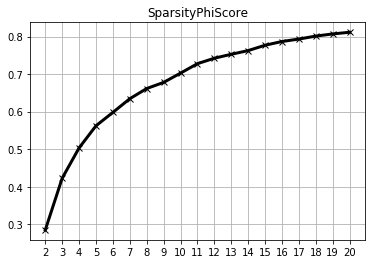

In [47]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [48]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

[0.2, 0.4, 0.5, 0.6, 0.7, 0.8]

In [49]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

{0.2: 1, 0.4: 1, 0.5: 3, 0.6: 3, 0.7: 8, 0.8: 3}

Text(0.5, 1.0, 'SparsityThetaScore')

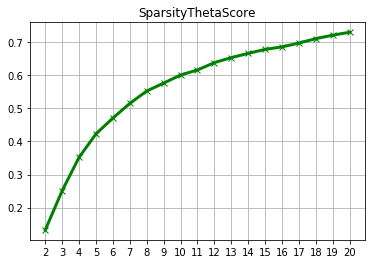

In [50]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [51]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [52]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

{0.1: 1, 0.2: 1, 0.3: 1, 0.4: 2, 0.5: 3, 0.6: 8, 0.7: 3}

Text(0.5, 1.0, 'PerplexityScore')

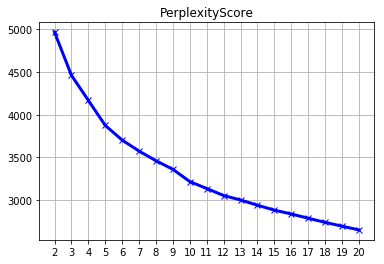

In [53]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [54]:
perplexity

[4967.63525390625,
 4462.1787109375,
 4167.822265625,
 3874.010009765625,
 3702.328125,
 3573.008544921875,
 3460.03857421875,
 3359.10791015625,
 3215.35595703125,
 3134.051025390625,
 3052.114990234375,
 2999.46533203125,
 2938.184326171875,
 2880.7138671875,
 2835.23291015625,
 2785.570068359375,
 2737.11181640625,
 2692.224365234375,
 2648.376708984375]

### select the best model

In [55]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

d_sphi:   {0.2: 1, 0.4: 1, 0.5: 3, 0.6: 3, 0.7: 8, 0.8: 3}
d_stheta: {0.1: 1, 0.2: 1, 0.3: 1, 0.4: 2, 0.5: 3, 0.6: 8, 0.7: 3}


In [56]:
select_topics = 17 # u should choose number of topic

best_model = model_list[select_topics-2]
print(best_model.num_topics)

17


### print top words for each topics

In [57]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['китай' 'остров' 'китайский' 'япония' 'судно' 'землетрясение' 'японский'
 'вода' 'километр' 'судный']
topic_1: ['выбор' 'процент' 'пост' 'парламент' 'кандидат' 'выборы' 'голос' 'обама'
 'президентский' 'отставка']
topic_2: ['германия' 'немецкий' 'процент' 'закон' 'беженец' 'право' 'фрг' 'мигрант'
 'гражданин' 'запрет']
topic_3: ['израиль' 'израильский' 'палестинский' 'газа' 'палестинец' 'хамас'
 'сектор' 'автономия' 'ливан' 'израильтянин']
topic_4: ['оон' 'иран' 'ядерный' 'переговоры' 'санкция' 'москва' 'встреча' 'совет'
 'украина' 'соглашение']
topic_5: ['самолёт' 'корея' 'аэропорт' 'кндр' 'борт' 'северный' 'пассажир' 'пилот'
 'южный' 'экипаж']
topic_6: ['ракета' 'оборона' 'самолёт' 'истребитель' 'ввс' 'вооружение' 'поставка'
 'система' 'вертолёт' 'корабль']
topic_7: ['пакистан' 'посольство' 'саудовский' 'пакистанский' 'аравия' 'дипломат'
 'бин' 'гражданин' 'венесуэла' 'россиянин']
topic_8: ['документ' 'расследование' 'администрация' 'доклад' 'министерство'
 'спецслужба' 'ко

### get topics-docs matrix

shape theta: (17, 149505)


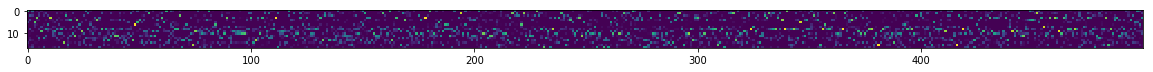

In [58]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [59]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16
114000,0.0,0.120209,0.289017,0.000000,0.000000,0.0,0.0,0.000000,0.044976,0.092979,0.000000,0.000000,0.083354,0.054387,0.000000,0.234570,0.080508
114001,0.0,0.427535,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.200911,0.308923,0.019398,0.000000,0.000000,0.043232,0.000000,0.000000
114002,0.0,0.000000,0.000000,0.000000,0.739109,0.0,0.0,0.032772,0.058955,0.000000,0.000000,0.000000,0.169163,0.000000,0.000000,0.000000,0.000000
114003,0.0,0.000000,0.000358,0.013044,0.052205,0.0,0.0,0.000000,0.145445,0.137862,0.000000,0.402026,0.000000,0.000000,0.000000,0.249059,0.000000
114004,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.059654,0.085132,0.000000,0.821206,0.000000,0.000000,0.000000,0.034008,0.000000


## DataViz

In [60]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16
1,0,1999,10,0.683445,0.000000,0.000000,0.0,0.034127,0.0,0.0,0.000000,0.0,0.276470,0.000000,0.0,0.000000,0.000000,0.000000,0.005957,0.000000
2,1,1999,10,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.285909,0.000000,0.0,0.136045,0.271316,0.000000,0.306730,0.000000
3,2,1999,10,0.556136,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.351782,0.000000,0.0,0.000000,0.000000,0.017952,0.074130,0.000000
4,3,1999,10,0.101627,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.218157,0.0,0.455273,0.113783,0.0,0.000000,0.000000,0.111160,0.000000,0.000000
5,4,1999,10,0.000000,0.205347,0.202154,0.0,0.000000,0.0,0.0,0.000000,0.0,0.500918,0.000000,0.0,0.000000,0.000000,0.000000,0.077150,0.014431


In [61]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (228, 17)


topic_0    topic_1    topic_2   topic_3    topic_4    topic_5  \
year month                                                                    
1999 8       0.000000   0.000000   0.000000  0.133241   0.000000   0.000000   
     9      18.758295   3.629810   7.951477  3.390939  13.021199  10.175158   
     10     16.103296  15.366961  17.398546  2.767444  20.310986   9.015329   
     11     16.157362  10.621184  13.562034  4.333177  23.564795  11.364163   
     12     17.288670  11.487720  10.815963  1.613612  16.693043  11.158900   

             topic_6    topic_7    topic_8    topic_9  topic_10  topic_11  \
year month                                                                  
1999 8      0.000000   0.412241   0.000000   1.262535  0.000000  0.000000   
     9      2.739736   5.365077  17.569893  18.010891  5.731905  1.842869   
     10     5.950027   8.689517  20.707052  16.485666  3.830847  1.940236   
     11     7.434222   9.613470  20.513163  21.804153  4.615212  1.678061   
     12     4.202004  10.680831  17.968748  16.654789  8.788818  3.242177   

             topic_12   topic_13   topic_14   topic_15   topic_16  
year month                                                         
1999 8       0.000000   0.000000   0.054777   0.089395   0.047810  
     9      10.051883   6.064826  11.404881   9.775319  15.515842  
     10     12.182145   8.520144  10.413133   7.415623  15.903045  
     11     12.527620  10.421334   8.301995  10.034438  14.453615  
     12     13.604198   9.920916   8.453091   8.727736  10.698787

### straightforward matrix heatmap

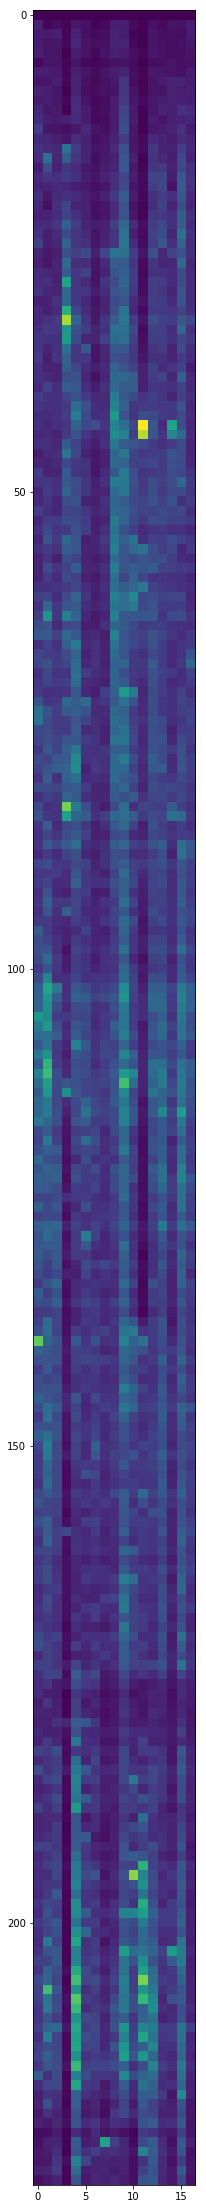

In [62]:
plt.figure(figsize=(10, 40))
plt.imshow(gb[topics])

## pygal

In [63]:
import pygal
from IPython.display import SVG, HTML

In [64]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [ ]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [66]:
line_chart.render_to_file(f'data/visualization/{name_dataset}_pygal.svg')

## joypy

In [67]:
import joypy # !pip install joypy

In [68]:
print(joined.shape)
joined.head()

(149652, 20)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16
1,0,1999,10,0.683445,0.000000,0.000000,0.0,0.034127,0.0,0.0,0.000000,0.0,0.276470,0.000000,0.0,0.000000,0.000000,0.000000,0.005957,0.000000
2,1,1999,10,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.285909,0.000000,0.0,0.136045,0.271316,0.000000,0.306730,0.000000
3,2,1999,10,0.556136,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.351782,0.000000,0.0,0.000000,0.000000,0.017952,0.074130,0.000000
4,3,1999,10,0.101627,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.218157,0.0,0.455273,0.113783,0.0,0.000000,0.000000,0.111160,0.000000,0.000000
5,4,1999,10,0.000000,0.205347,0.202154,0.0,0.000000,0.0,0.0,0.000000,0.0,0.500918,0.000000,0.0,0.000000,0.000000,0.000000,0.077150,0.014431


In [69]:
joined['year_month'] = joined.apply(lambda x: str(int(x.year)) +'-'+ str(int(x.month)) + '-01', axis=1)
joined.reset_index(inplace=True)

joined.head()

,index,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,...,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,year_month
0,1,0,1999,10,0.683445,0.000000,0.000000,0.0,0.034127,0.0,...,0.0,0.276470,0.000000,0.0,0.000000,0.000000,0.000000,0.005957,0.000000,1999-10-01
1,2,1,1999,10,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.285909,0.000000,0.0,0.136045,0.271316,0.000000,0.306730,0.000000,1999-10-01
2,3,2,1999,10,0.556136,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.351782,0.000000,0.0,0.000000,0.000000,0.017952,0.074130,0.000000,1999-10-01
3,4,3,1999,10,0.101627,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.455273,0.113783,0.0,0.000000,0.000000,0.111160,0.000000,0.000000,1999-10-01
4,5,4,1999,10,0.000000,0.205347,0.202154,0.0,0.000000,0.0,...,0.0,0.500918,0.000000,0.0,0.000000,0.000000,0.000000,0.077150,0.014431,1999-10-01


In [70]:
joined_melt = joined.melt('year_month', var_name='topic', value_name='text')
print(joined_melt.shape)
joined_melt.head()

(3142692, 3)


,year_month,topic,text
0,1999-10-01,index,1.0
1,1999-10-01,index,2.0
2,1999-10-01,index,3.0
3,1999-10-01,index,4.0
4,1999-10-01,index,5.0


In [71]:
# select only topic_*
joined_melt_new = joined_melt[(joined_melt.topic!='docID') & (joined_melt.topic!='index')
                              & (joined_melt.topic!='year') & (joined_melt.topic!='month')]
print(joined_melt_new.shape)
joined_melt_new.topic.value_counts()

(2544084, 3)


topic_11    149652
topic_13    149652
topic_14    149652
topic_12    149652
topic_16    149652
topic_15    149652
topic_8     149652
topic_1     149652
topic_9     149652
topic_0     149652
topic_7     149652
topic_4     149652
topic_6     149652
topic_2     149652
topic_3     149652
topic_5     149652
topic_10    149652
Name: topic, dtype: int64

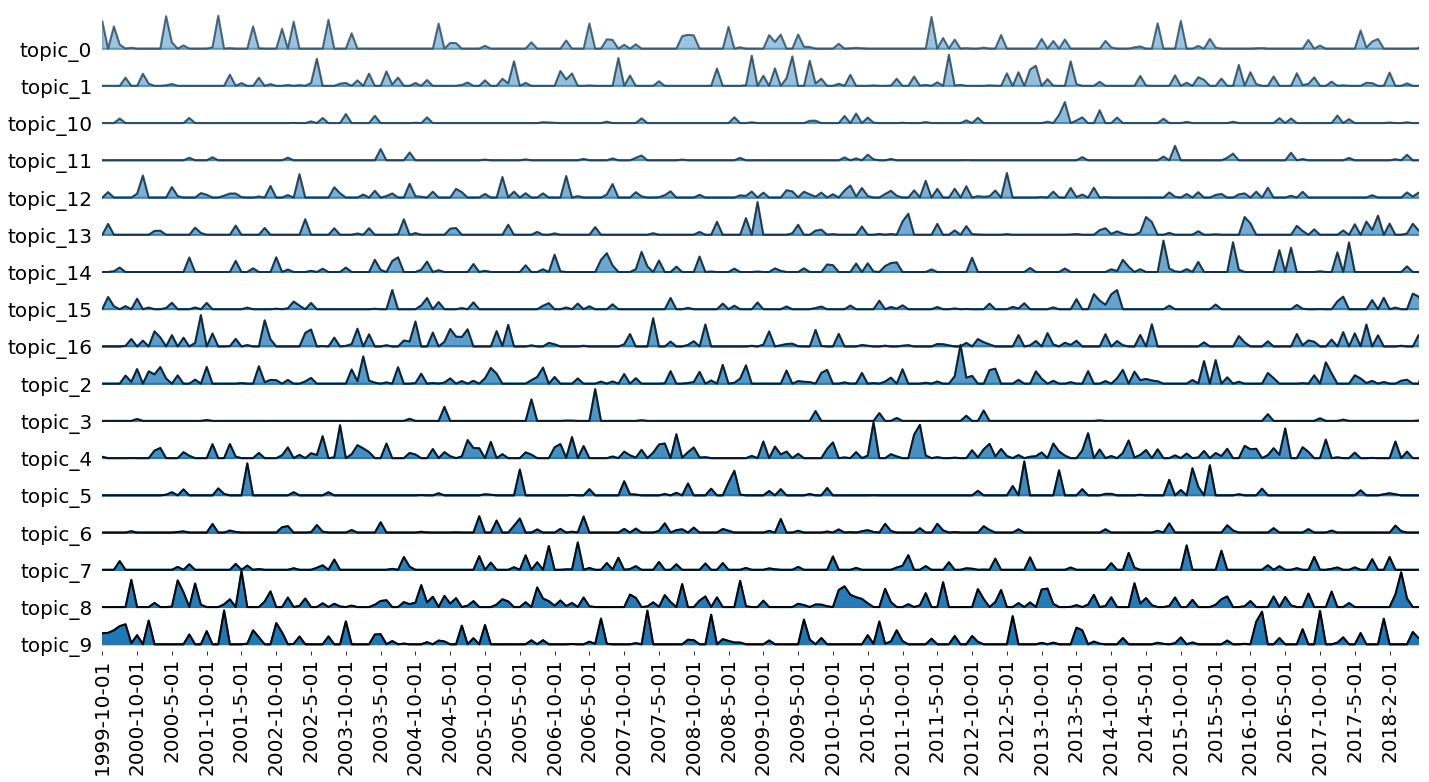

In [72]:
labels = sorted(joined_melt_new['year_month'].unique())

fig, axes = joypy.joyplot(joined_melt_new, by='topic', column='text', figsize=(20, 10),xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True, linecolor="k", linewidth=2,
                          kind='values', fade=True, xrot=90, x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [74]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")